# Figure scoring patterns

In [ ]:
%%javascript
Jupyter.notebook.session.restart({kernel_name: 'python2'})

<IPython.core.display.Javascript object>

After running the cell above you can go ahead and run the ones below, even if the cell above appears 'busy'

In [1]:
import warnings
warnings.filterwarnings("ignore")
from brian2 import *
from multiprocessing import *
from scipy.stats import norm,circmean
from scipy.signal import fftconvolve

## Setting up the BIPD distribution

In [2]:
__all__ = ['generate_random_mcalpine_et_al_2001_bds']

def fixup(s):
    s = s.replace(',', '.')
    s = s.split('\n')
    s = [map(float, w.split('    ')) for w in s if w]
    f, bitd = zip(*s)
    f = array(f) * kHz
    bitd = array(bitd) * usecond
    return f, bitd

fig_2a_means = '''
0,09455    707,10712
0,16542    520,84442
0,23318    361,37778
0,29635    277,76535
0,35333    232,09654
0,41458    182,66420
0,46000    163,59335
0,51884    205,06943
0,57556    148,14299
0,61844    113,97392
0,68096    147,91190
0,75553    117,48437
0,80553    121,18188
0,99987    109,52809
'''

fig_2a_means_plus_stds = '''
0,09879    1125,42432
0,19757    819,93372
0,30073    604,84766
0,39557    412,23495
0,49462    412,60233
0,59540    333,41052
0,68949    242,79839
0,78939    307,37531
0,89622    250,80063
0,97863    201,73302
1,09955    209,49567
1,23526    228,61478
1,34885    179,54718
1,75320    191,33490
'''
_, mean_bitd = fixup(fig_2a_means)
f, bitd_mean_plus_std = fixup(fig_2a_means_plus_stds)
std_bitd = bitd_mean_plus_std - mean_bitd

def generate_random_mcalpine_et_al_2001_bds(cf, N, std_factor=1.0):
    fmid = 0.5 * (f[1:] + f[:-1])
    I = digitize(cf, fmid)
    mu = mean_bitd[I] * 2 * cf[0] * 180.0
    sigma = std_bitd[I] * std_factor * 2 * cf[0] * 180.0
    x_axis = np.arange(-180, 180, 360.0 / N)

    ##Creating the 2-sided BIPD distribution
    dist_bipd = exp(-(mu - x_axis) ** 2 / (2 * sigma ** 2)) + exp(-(-mu - x_axis) ** 2 / (2 * sigma ** 2))
    dist_bipd = dist_bipd / max(dist_bipd)
    dist_bipd_recentered = np.concatenate((dist_bipd[int(N / 2):int(N)], dist_bipd[0:int(N / 2)]))

    return dist_bipd_recentered

## Setting up the inhibition kernel

In [3]:
def patt_act_gen(params,f_m,ipd,dyn=False):
    fm=f_m*Hz
    fc=params['f_c']*Hz
    taub=params['tau_b']*ms
    fm_max=64*Hz
    
    # Number of envelope cycles
    n=int(1 + np.ceil(3*taub*fm_max))
    if n % 2 == 0:
        n += 1
    # Time discretization, delta_t=n_t/fm
    t = linspace(0,1,n*params['n_t'])*(1.0*n/fm)
    
    # BIPD discretization, delta_bipd=2*pi/n_bipd
    bipd = linspace(0,2*n*pi,n*params['n_bipd'],endpoint=False)%(2*pi)
    
    # Creating time/bipd 2Dspace
    T, BIPD = meshgrid(t, bipd)
    
    # Stimulus  Envelope 
    A = 0.5*clip(1-params['m']*cos(2*pi*fm*T),0,Inf)
    
    # Converting starting phase to radian.
    dphi_phase_rad=params['dphi_phase']*pi/180.0
    
    # Dynamic or static ipd
    if dyn:
        PHI=(2*pi*fm*T+dphi_phase_rad)%(2*pi)
    else:
        PHI=ipd%(2 * pi)
    # Tuning curve
    TC=(cos((BIPD - PHI) / 2))** params['k']
    
    # modeling the neural activity
    patt_act = TC * A
    
    # Defining borders of the region of interest after convolution
    bipd_inf = int((params['n_bipd'] * n) * ((n - 1) / (2.0 * n)))
    bipd_sup = int((params['n_bipd'] * n) * ((n + 1) / (2.0 * n)))
    t_inf = int(params['n_t'] * n * (1 - 1.0 / n))
    t_sup = int(params['n_t'] * n)
    
    # Producing BIPD distribution based on carrier frequency
    if params['mcAlp_bipd']:
        h_bipd = np.tile(generate_random_mcalpine_et_al_2001_bds([fc], params['n_bipd'], std_factor=1.0), n)
        patt_act_weighted = patt_act*h_bipd[..., np.newaxis]
    else:
        patt_act_weighted = patt_act

    # Setting up the number of neurons participating to the inhibition
    bipd_window = int(params['sigma_k']*params['n_bipd'])
    # delta_t
    pix_t = 1.0/(params['n_t'] * fm)
    #delta_bipd
    pix_bipd = 2*pi/params['n_bipd']
    # Setting up the kernel
    # t-axis
    ksize_t = int(3.*taub/pix_t)
    dt = arange(-ksize_t, ksize_t + 1) * pix_t
    # BIPD axis
    dbipd = arange(-floor(bipd_window/2), floor(bipd_window/2) + 1) * pix_bipd
    DT, DBIPD = meshgrid(dt, dbipd)
    
    kernel0 = where(DT >= 0, 0, exp(DT/taub))

    kernel0[dbipd.shape[0] / 2, :] = 0
    kernel0[:, kernel0.shape[1] / 2] = 0
    
    # Normalization of the kernel
    kernel = kernel0 * pix_t / (1.0 * taub)
   
    # 2D convolution over multiple cycles to remove any border effects
    inh_layer = fftconvolve(patt_act_weighted, kernel[::-1, ::-1], mode='same')
    
    # Crop resulting images to zone of interest, ie the last 2 envelope cycles
    patt_act_weighted_inh= clip(patt_act_weighted - params['gamma'] * inh_layer, 0, inf)
    patt_act = np.concatenate((patt_act[bipd_inf:bipd_sup, t_inf:t_sup], 
                               patt_act[bipd_inf:bipd_sup, t_inf:t_sup]), 1)
    patt_act_weighted = np.concatenate((patt_act_weighted[bipd_inf:bipd_sup, t_inf:t_sup],
                                        patt_act_weighted[bipd_inf:bipd_sup, t_inf:t_sup]), 1)
    patt_act_weighted_inh = np.concatenate((patt_act_weighted_inh[bipd_inf:bipd_sup, t_inf:t_sup],
                                            patt_act_weighted_inh[bipd_inf:bipd_sup, t_inf:t_sup]),1)
    inh_layer = np.concatenate((inh_layer[bipd_inf:bipd_sup, t_inf:t_sup],
                                inh_layer[bipd_inf:bipd_sup, t_inf:t_sup]),1)

    return patt_act,patt_act_weighted,patt_act_weighted_inh,kernel,inh_layer

## Creation of the static pointer IPDs

In [4]:
def static_ipd_patt_act_gen(params,f_m,ipd,procnum=0,return_dict=None):
    _,_,patt_act_weighted_inh,_,_=patt_act_gen(params,f_m,ipd,dyn=False)
    return_dict[procnum]=patt_act_weighted_inh

## Creation of the stimulus with the dynamic IPD

In [5]:
def dyn_ipd_patt_act_gen(params,f_m):
    patt_act,patt_act_weighted,patt_act_weighted_inh,kernel,inh_layer=patt_act_gen(params,f_m,0,dyn=True)
    return patt_act,patt_act_weighted,patt_act_weighted_inh,kernel,inh_layer

In [6]:
def pointer_ipd(params,multiproc):
    ##Use of multiprocessing to make the generation of the training data faster
    n = 2
    ipds = np.linspace(0, 2 * pi, params['num_static_ipd'], endpoint=False)  
    num_fm = 5
    pointer_ipd_patts = np.zeros((1, num_fm, params['num_static_ipd'], params['n_bipd'], n*params['n_t']))
    proc = []
    manager = Manager()
    return_dict = manager.dict()
    
    #Without multiprocessing
    if not multiproc:
        for i in xrange(num_fm):
            for j in xrange(params['num_static_ipd']):
                pointer_ipd_patts[i,j,:,:]=static_ipd_patt_act_gen(params,
                                                            2**(i+2),ipds[j])
    else:
    # With multiprocessing
        for i in xrange(num_fm):
            for j in xrange(params['num_static_ipd']):
                proc.append(Process(target=static_ipd_patt_act_gen, args=(params,2**(i+2),ipds[j],
                i*params['num_static_ipd'] + j,return_dict,)))

        for i in xrange(num_fm):
            for j in xrange(params['num_static_ipd']):
                proc[i * params['num_static_ipd'] + j].start()

        for i in xrange(num_fm):
            for j in xrange(params['num_static_ipd']):
                proc[i * params['num_static_ipd'] + j].join()

        for i in xrange(num_fm):
            for j in xrange(params['num_static_ipd']):
                pointer_ipd_patts[:, i, j, :, :] = return_dict[i*params['num_static_ipd'] + j]

    return pointer_ipd_patts

In [7]:
def dyn_ipd(params):

    n = 2
    num_fm = 5
    dyn_ipd_patts = np.zeros((1, num_fm, params['n_bipd'], 2 * params['n_t']))

    for i in xrange(num_fm):
        _,_,dyn_ipd_patts[0, i, :],_,_=dyn_ipd_patt_act_gen(params,2**(i+2))
    return dyn_ipd_patts

## Similarity scoring

In [8]:
def similarity_scoring(params,dyn_ipd_patts,static_ipd_patts,decision_window,width_frame):
    num_fm = 5
    scores = np.zeros((num_fm, params['num_static_ipd']))
    std_scores = np.zeros((num_fm))
    results = np.zeros(num_fm)
    
    #Implementing 2D dot product
    for i in xrange(num_fm):
        for j in xrange(params['num_static_ipd']):
            if np.any(dyn_ipd_patts[i][:, decision_window[0]:decision_window[1]]) and np.any(
                    static_ipd_patts[i, j, :, decision_window[0]:decision_window[1]]):
                scores[i, j] = sum(dyn_ipd_patts[i][:, decision_window[0]:decision_window[1]]
                                   * static_ipd_patts[i, j, :, decision_window[0]:decision_window[1]])
                
                #Normalization of the similarity scores
                scores[i, j] /= (np.linalg.norm(dyn_ipd_patts[i][:, decision_window[0]:decision_window[1]]) *
                                 np.linalg.norm(static_ipd_patts[i, j, :, decision_window[0]:decision_window[1]]))

    # Matching the output IPD to the IPD maximizing the similarity scoring
    # And correcting for phase at t=0
    results = np.argmax(scores, 1) * 360.0 / params['num_static_ipd'] - params['dphi_phase']
    results %= 360
    
    # Computing circular std for each modulation frequency, at the similarity scoring level 
    sum_sin = np.zeros((num_fm))
    sum_cos = np.zeros((num_fm))
    ipds = np.linspace(0, 2 * pi, params['num_static_ipd'], endpoint=False)
    for k in xrange(num_fm):
        for j in xrange(params['num_static_ipd']):
            sum_sin[k] += np.sin(ipds[j] + 0 * params['dphi_phase'] * pi / 180.0) * scores[k, j]
            sum_cos[k] += np.cos(ipds[j] + 0 * params['dphi_phase'] * pi / 180.0) * scores[k, j]
        std_scores[k] = sqrt(-np.log((1.0 / sum(scores[k, :]) ** 2) * (sum_sin[k] ** 2 + sum_cos[k] ** 2))) * 180.0 / pi

    return scores, results, std_scores

## Figure scoring patterns

In [43]:
def fig_scoring_patts_pop(params,multiproc='off'):
    
    static_ipd_patts = pointer_ipd(params,multiproc)
    dyn_ipd_patts = dyn_ipd(params)
    decision_window_pix = [params['n_t'], 2*params['n_t'] - 1]

    res=similarity_scoring(params, dyn_ipd_patts[0], static_ipd_patts[0], decision_window_pix,
            decision_window_pix[1] - decision_window_pix[0])
    
    dyn_fm=[]
    fm_array=[4,8,16,32,64]*Hz
    num_fm=len(fm_array)
    ftsize=22
    for i in xrange(num_fm):
        dyn_fm.append(dyn_ipd_patt_act_gen(params,2**(i+2)))
    
    
    fig=figure(figsize=(20,10))
    gs = GridSpec(4, 3) 
    
    subplot(gs[0:2,0:1])
    imshow(dyn_fm[0][2][:,params['n_t']:2*params['n_t']],origin='lower left', interpolation='nearest',
           aspect='auto',extent=[0,1.0/4,0,360],cmap='viridis')
    cs = contour(dyn_fm[0][0][:,params['n_t']:2*params['n_t']], origin='lower',
           aspect='auto',levels=[0.15, 0.5, 0.9],linewidths=2.5, colors='w',extent=[0,1.0/4,0,360])
    clabel(cs, colors='w', inline=True)
    #xlabel('Time (second)',fontsize=18)
    ylabel('BIPD (deg)',fontsize=ftsize)
    xticks([round(0.0,1),round(1.0/8,4),round(1.0/4,4)],fontsize=ftsize)
    yticks([0,90,180,270,360],fontsize=ftsize)
    ax = gca().twiny()
    ax.cla()
    ax.set_xlim([0,360])
    ax.set_xlabel('Phase (deg)',fontsize=ftsize)
    xticks([0,90,180,270,360],fontsize=ftsize)
    yticks([0,90,180,270,360],fontsize=ftsize)
    
    subplot(gs[2:4,0:1])
    imshow(dyn_fm[4][2][:,params['n_t']:2*params['n_t']],origin='lower left', interpolation='nearest',
           aspect='auto',extent=[0,1.0/64,0,360],cmap='viridis')    
    cs = contour(dyn_fm[4][0][:,params['n_t']:2*params['n_t']], origin='lower', 
           aspect='auto',levels=[0.15, 0.5, 0.9],linewidths=2.5, colors='w',extent=[0,1.0/64,0,360])
    clabel(cs, colors='w', inline=True)
    yticks([0,90,180,270,360],fontsize=18)
    xticks([round(0.0,1),round(1.0/128,4),round(1.0/64,4)],fontsize=ftsize)
    xlabel('Time (s)',fontsize=ftsize)
    ylabel('BIPD (deg)',fontsize=ftsize)
    ax1 = gca().twiny()
    ax1.cla()
    ax1.set_xlim([0,360])
    #ax1.set_xlabel('Phase (deg)',fontsize=18)
    xticks([0,90,180,270,360],fontsize=ftsize)
    yticks([0,90,180,270,360],fontsize=ftsize)
    
    ax2=subplot(gs[0:4,1:3])
    title('Similarity scoring',fontsize=ftsize)
    imshow(transpose(res[0]),origin='lower left', interpolation=None, aspect='auto',
           extent=[4,64,0,360],cmap='viridis')
    errorbar(fm_array, res[1],yerr=res[2], fmt='-ko',lw=3.5,label='Model')
    errorbar(fm_array, [37, 40, 62, 83, 115],yerr=[46, 29, 29, 31,37], fmt='--r',lw=3.5, 
             label='Data',linewidth=2)
    xticks([4,8,16,32,64],fontsize=ftsize)
    yticks([0,90,180,270,360],fontsize=ftsize)
    ylabel('BIPD (deg)',fontsize=ftsize)
    xlabel('Modulation frequency (Hz)',fontsize=ftsize)
    xlim(4,66)
    ylim(0,360)
    cbar=colorbar()
    cbar.ax.tick_params(labelsize=20)
    plt.tick_params(top='off', bottom='on', left='on', right='off', labelleft='on', labelbottom='on')
    ax2.spines['left'].set_visible(True)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    legend(fontsize=22,bbox_to_anchor=[0.95,1])
    
    text(-54, 377, 'A',fontsize=28)
    text(-54, 160, 'B',fontsize=28)
    text(0, 377, 'C',fontsize=28)
    text(-52, 282, '4 Hz',fontsize=28,rotation=90)
    text(-52, 87, '64 Hz',fontsize=28,rotation=90)
    tight_layout()
    savefig('fig_scoring_patts_pop.pdf',bbox_inches='tight')


In [44]:
tau_b=6.0
sigma_k=0.7
gamma=0.07
mcAlp_bipd=True
n_t=250
n_bipd=100
dphi_phase=0
f_c=500
num_static_ipd=40
m=1.1
k=4

params={'tau_b':tau_b,'sigma_k':sigma_k,'gamma':gamma,'mcAlp_bipd':mcAlp_bipd,'dphi_phase':dphi_phase,'n_t':n_t,
        'n_bipd':n_bipd,'f_c':f_c,'num_static_ipd':num_static_ipd,'m':m,'k':k}

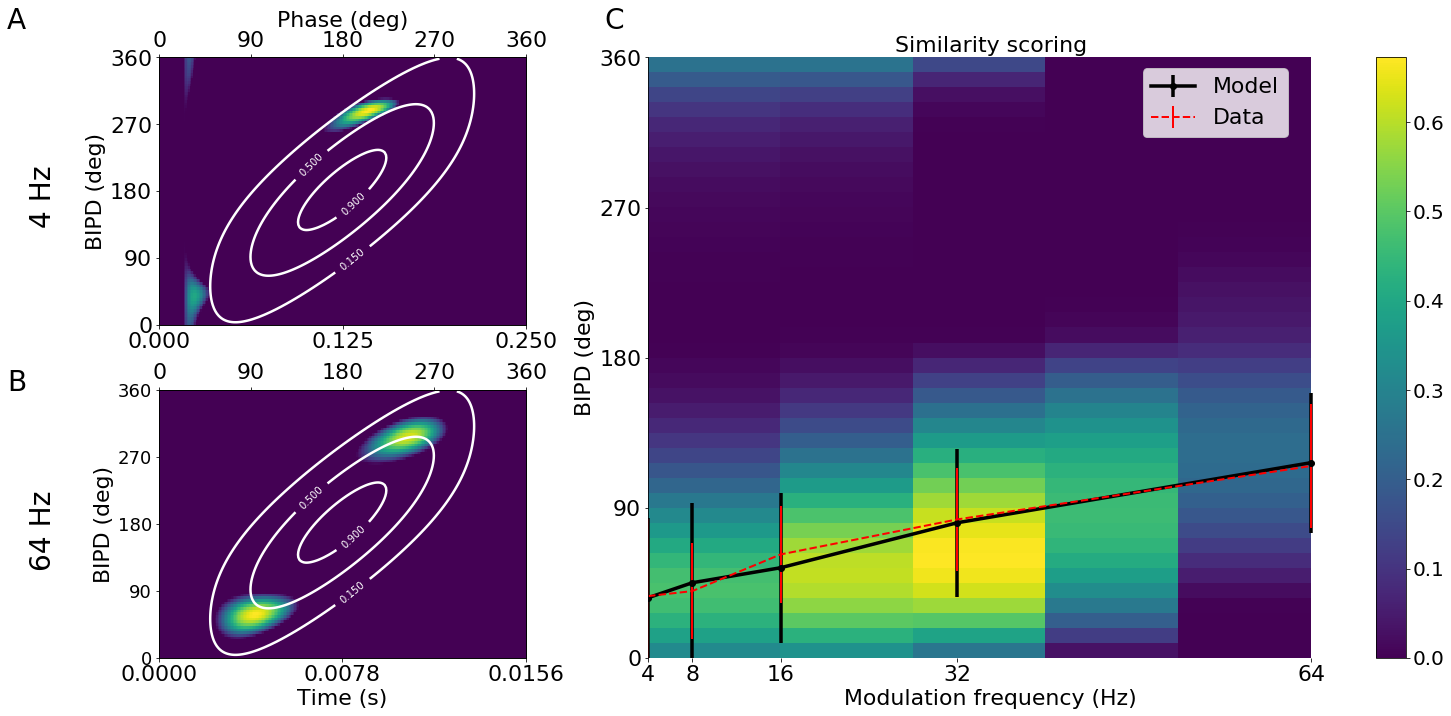

In [45]:
fig_scoring_patts_pop(params,multiproc='on')